In [2]:
%matplotlib widget

# MRI for BRAIN - Diffusion Tractography Practical

In [3]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
import dipy.reconst.dti as dti
from dipy.core.gradients import gradient_table
from dipy.data import get_sphere
from dipy.viz import window, actor
from pathlib import Path

## Exploring the data

### T1 image

In [4]:
t1_nifti = nib.load("data/T1w_acpc_dc_restore_1.25.nii.gz")

In [5]:
print(t1_nifti.header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 145 174 145   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [-1.    1.25  1.25  1.25  2.4   0.    0.    0.  ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'FSL5.0'
aux_file        : b''
qform_code      : mni
sform_code      : mni
quatern_b       : 0.0
quatern_c       : 1.0
quatern_d       : 0.0
qoffset_x       : 90.0
qoffset_y       : -126.0
qoffset_z       : -72.0
srow_x          : [-1.25 

In [6]:
t1_nifti.affine

array([[  -1.25,    0.  ,    0.  ,   90.  ],
       [   0.  ,    1.25,    0.  , -126.  ],
       [   0.  ,    0.  ,    1.25,  -72.  ],
       [   0.  ,    0.  ,    0.  ,    1.  ]])

Nifti coordinates <br>
https://nipy.org/nibabel/coordinate_systems.html <br>
Nifti headerfile: <br>
https://brainder.org/2012/09/23/the-nifti-file-format/

In [7]:
t1_data = t1_nifti.get_fdata()
t1_data.shape

(145, 174, 145)

Write about RAS+ orientation here.
Figure out where voxel (0, 0, 0), the midpoint, and voxel (144, 173, 144) are in patient space? ((why is 144, 173, 144) the last voxel)

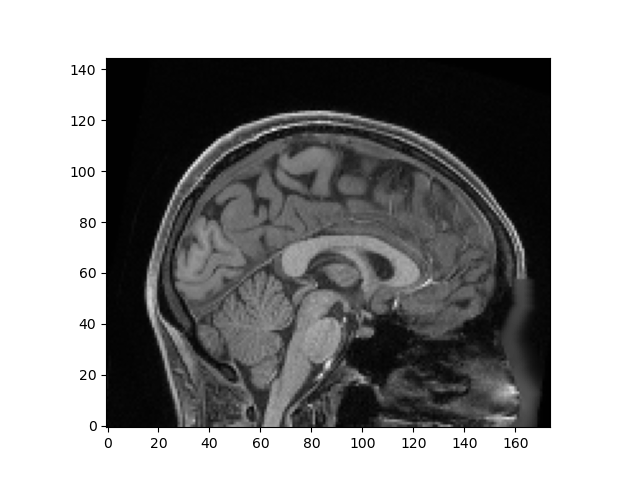

In [8]:
fig, ax = plt.subplots()
ax.imshow(t1_data[144//2, :, :].T, cmap="gray", origin="lower")

Why .T? Why origin = lower? Think about the orientation.

In [9]:
def show_slices(slices):

   """ Function to display row of image slices, taken from https://nipy.org/nibabel/coordinate_systems.html """

   fig, axes = plt.subplots(1, len(slices))

   for i, slice in enumerate(slices):

       axes[i].imshow(slice.T, cmap="gray", origin="lower")

In [10]:
dif_nifti = nib.load("data/dwi-b1000_down_25.nii.gz")

In [11]:
print(dif_nifti.header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b'FSL5.0'
extents         : 16384
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  4  72  87  72 108   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [-1.   2.5  2.5  2.5  1.   0.   0.   0. ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'MRtrix version: 3.0.4'
aux_file        : b''
qform_code      : scanner
sform_code      : scanner
quatern_b       : 0.0
quatern_c       : 1.0
quatern_d       : 0.0
qoffset_x       : 88.75
qoffset_y       : -125.375
qoffset_z       : -70

In [12]:
dif_data = dif_nifti.get_fdata()
dif_data.shape

(72, 87, 72, 108)

Load nifti into variable called dif_nifti, get the data from the dif_nifti and store this in dif_data. Note: for storage size reasons we've decreased the resolution to ... <br>
Explore header info of dif_nifti. <br>
What is the shape of dif_data? <br>
What is stored in the last dimension of dif_data?

In [13]:
def parse_bvecs(path: Path) -> np.array:
    with open(path, "r") as f:
        x, y, z = f.readlines()

    x = np.array(x.split(), dtype=float)
    y = np.array(y.split(), dtype=float)
    z = np.array(z.split(), dtype=float)

    return np.stack([x, y, z], axis=1)


def parse_bvals(path: Path) -> np.array:
    with open(path, "r") as f:
        x = f.readline()

    return np.array([int(value) for value in x.strip().split()], dtype=int)

def spherical_to_cartesian(spherical_vec: np.array) -> np.array:
    rho = spherical_vec[..., 0]
    phi = spherical_vec[..., 1]
    theta = spherical_vec[..., 2]

    return np.stack(
        [
            rho * np.sin(phi) * np.cos(theta),
            rho * np.sin(phi) * np.sin(theta),
            rho * np.cos(phi),
        ],
        axis=-1,
    )

def plot_bvecs(b_vecs: np.array) -> None:
    fig, ax = plt.subplots(subplot_kw={"projection": "3d", "computed_zorder": False})

    # Plot b_vecs
    ax.scatter(b_vecs[:, 0], b_vecs[:, 1], b_vecs[:, 2], color="red", zorder=4)
    ax.scatter(-b_vecs[:, 0], -b_vecs[:, 1], -b_vecs[:, 2], color="red", zorder=4)
    
    # plot sphere
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    x = np.outer(np.cos(u), np.sin(v))
    y = np.outer(np.sin(u), np.sin(v))
    z = np.outer(np.ones(np.size(u)), np.cos(v))
    
    ax.plot_surface(x, y, z, alpha=1, shade=False)

    # ax.set_xlim([-1, 1])
    # ax.set_ylim([-1, 1])
    # ax.set_zlim([-1, 1])

    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    ax.set_aspect("equal")
    #ax.set_axis_off()
    plt.show()

In [14]:
bvec_path = Path("data/dwi-b1000.bvec")
bval_path = Path("data/dwi-b1000.bval")
bvecs = parse_bvecs(bvec_path)
bvals = parse_bvals(bval_path)

Look at the b-values, what do these mean? <br>
Look at the b-vectors, what do these mean?

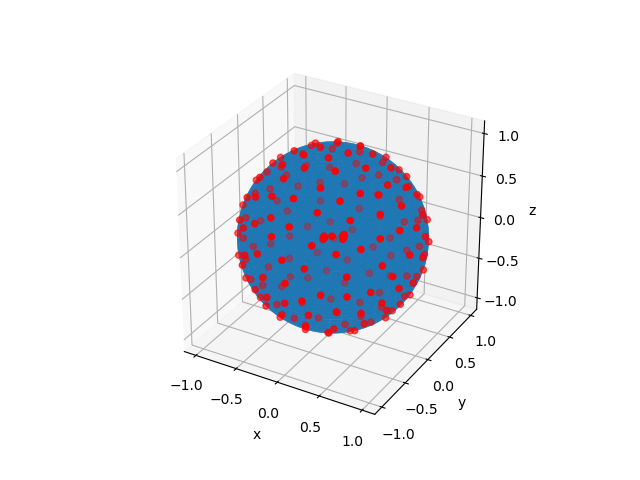

In [15]:
plot_bvecs(bvecs)

Try to plot only the b-vectors of the non b0 (b=5) acquisitions.

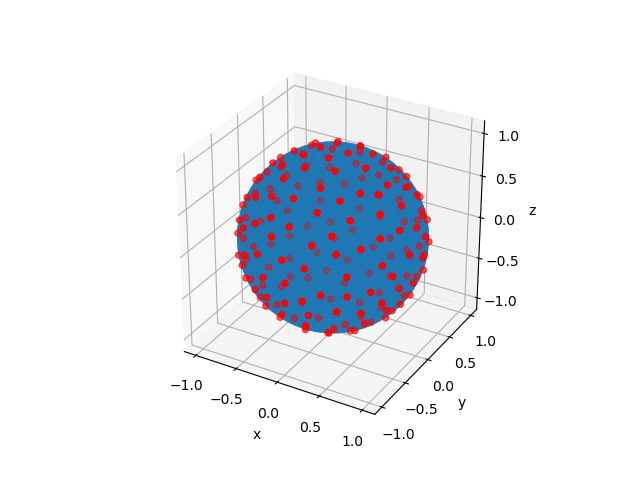

In [16]:
plot_bvecs(bvecs[bvals != 5])

Look at the distribution of the gradient direction vectors on a sphere. <br>
Why is it important that the gradient directions are (almost) evenly distributed? <br>
Plot the first 3 (non b0) b-vectors, what do you expect to see?

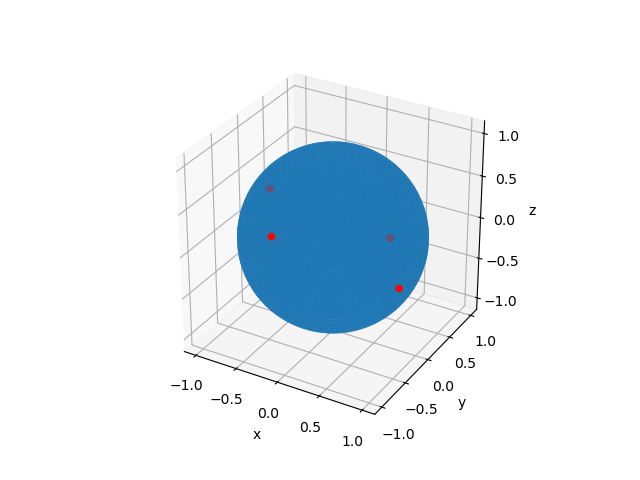

In [17]:
plot_bvecs(bvecs[bvals != 5][:2])

In [18]:
dif_data_sel = dif_data[..., bvals !=5]

In [19]:
# (72, 87, 72, 108)
mid_sagital = dif_data_sel[72//2, :, :, 0]
mid_coronal = dif_data_sel[:, 87//2, :, 0]
mid_transv = dif_data_sel[:, :, 36, 0]

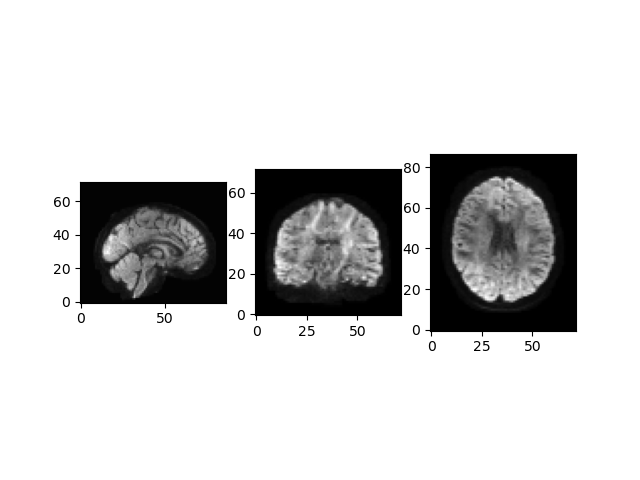

In [20]:
show_slices([mid_sagital, mid_coronal, mid_transv])

Inspect the slices of the first gradient direction. <br>
What does a high signal intensity mean?

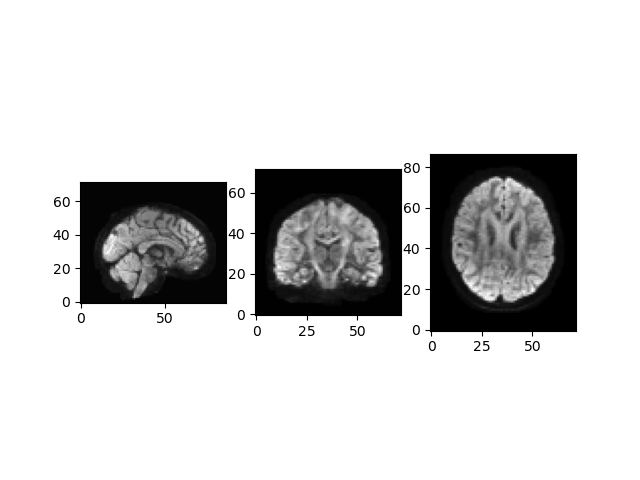

In [21]:
# (72, 87, 72, 108)
mid_sagital = dif_data_sel[72//2, :, :, 1]
mid_coronal = dif_data_sel[:, 87//2, :, 1]
mid_transv = dif_data_sel[:, :, 72//2, 1]
show_slices([mid_sagital, mid_coronal, mid_transv])

The first gradient direction runs almost paralel to the x-axis, the second runs almost paralel to the y-axis. <br>
A common area to inspect in diffusion MRI images is the corpus callosum (CC), which connects the left and right hemispheres of the brain. <br>
Can you find the CC in the mid-coronal images of the first two gradient images? <br>
Are the signal intensities in the CC what you would expect?

- Compute visualize tensors
- Make tissue mask (5ttgen fsl)
- Redo tensors, do DTI metrics
- DTI metric calculations on segments
- Do fiber tracking on DTI for CC
- Explore FODs
- Do fiber tracking on FODs

In [22]:
g_tab = gradient_table(bvals, bvecs)

In [23]:
tensor_model = dti.TensorModel(g_tab)

In [24]:
tensor_fit = tensor_model.fit(dif_data)

In [51]:
scene = window.Scene()
sphere = get_sphere ('repulsion724')
tensor_odfs = tensor_model.fit(dif_data[20:50, 35:75, 35:36]).odf(sphere)
odf_actor = actor.odf_slicer(tensor_odfs, sphere=sphere, scale=0.5, colormap=None)
scene.add(odf_actor)

In [54]:
window.record(scene, n_frames=1, size=(600, 600))

In [46]:
window.show(scene)

In [55]:
#fit(data, mask)

Type:           TensorModel
String form:    <dipy.reconst.dti.TensorModel object at 0x000002445D512110>
File:           c:\users\20230392\appdata\local\mambaforge\envs\mri_for_brain\lib\site-packages\dipy\reconst\dti.py
Docstring:     
Diffusion Tensor
    
Init docstring:
A Diffusion Tensor Model [1]_, [2]_.

Parameters
----------
gtab : GradientTable class instance

fit_method : str or callable
    str can be one of the following:

    'WLS' for weighted least squares
        :func:`dti.wls_fit_tensor`
    'LS' or 'OLS' for ordinary least squares
        :func:`dti.ols_fit_tensor`
    'NLLS' for non-linear least-squares
        :func:`dti.nlls_fit_tensor`
    'RT' or 'restore' or 'RESTORE' for RESTORE robust tensor
        fitting [3]_
        :func:`dti.restore_fit_tensor`

    callable has to have the signature:
      fit_method(design_matrix, data, *args, **kwargs)

return_S0_hat : bool
    Boolean to return (True) or not (False) the S0 values for the fit.

args, kwargs : argument